In [1]:
%matplotlib inline

In [2]:
#Set script to run optimization
run_fit = True

# Importing Libraries

Importing libraries for script

In [3]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant,Variable
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.output_points_3d import PointsOutput3D
from pynamics.constraint import AccelerationConstraint,KinematicConstraint
from pynamics.particle import Particle
import pynamics.integration
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi,sin
import sympy
from sympy import sqrt
import math
import logging
import scipy.optimize
import pynamics.integration
import pynamics.system
import numpy.random
import scipy.interpolate
import scipy.optimize
import cma
import pandas as pd
import idealab_tools.units
from matplotlib import animation, rc
from IPython.display import HTML


system = System()
pynamics.set_system(__name__,system)

# Constants of System

In this block of code we are defining all the constants of our system that we will use for our simulation

In [4]:
#[0.01982164 0.03916815]

#seg = segment, t = tail
seg_l = 0.0276
t_l = 0.0276
seg_h = 0.01
len_factor = 5.5

#Set segment lengths
l = Constant(seg_l,'l',system) #Segment Length, Formula:seg_len
lT = Constant(seg_l,'tail',system) #Tail Length, Formula:tail_len
lP = Constant(seg_l*len_factor,'lP',system) #Constrained length, Forumla:seg_len*constrainted_length_factor

#Set masses, 666.7 is density of laminate structure
m = Constant(666.7*seg_l*seg_h*0.001,'m',system) #Segment Mass, Formula:666.7*seg_len*seg_h*seg_th
mT = Constant(666.7*t_l*seg_h*0.001,'mT',system) #Tail Mass, Formula:666.7*tail_len*seg_h*seg_th

b = Constant(2.148e-6,'b',system)
k = Constant(1.599e-4,'k',system)
rho = Constant(998,'rho',system)
area_p = Constant(seg_l*seg_h,'area_p',system) #area of flat plates
area_f = Constant(seg_h*0.001,'area_f',system) #area of flat plates

freq = Constant(1,'freq',system) #frequency of head oscilation
amp = Constant(40*pi/180,'amp',system) #maximum pitch angle of servo 

Ixx = Constant(1/12*(666.7*seg_l*seg_h*0.001)*(seg_h**2 + 0.001**2),'Ixx',system) #Formula: 1/12*666.7*seg_len*seg_h*seg_th*(seg_h**2 + seg_th**2
Iyy = Constant(1/12*(666.7*seg_l*seg_h*0.001)*(seg_h**2 + seg_l**2),'Iyy',system) #Formula: 1/12*(666.7*seg_len*seg_h*seg_th)*(seg_h**2 + seg_len**2)
Izz = Constant(1/12*(666.7*seg_l*seg_h*0.001)*(seg_l**2 + 0.001**2),'Izz',system) #Formula: 1/12*(666.7*seg_len*seg_h*seg_th)*(seg_len**2 + seg_th**2)
Ixx_T = Constant(1/12*(666.7*t_l*seg_h*0.001)*(seg_h*2 + 0.001**2),'Ixx_T',system) #Formula: 1/12*(666.7*tail_len*seg_h*seg_th)*(seg_h*2 + seg_th**2) 
Iyy_T = Constant(1/12*(666.7*t_l*seg_h*0.001)*(seg_h**2 + t_l**2),'Iyy_T',system) #Formula: 1/12*(666.7*tail_len*seg_h*seg_th)*(seg_h**2 + tail_len**2)
Izz_T = Constant(1/12*(666.7*t_l*seg_h*0.001)*(t_l**2 + 0.001**2),'Izz_T',system) #Formula: 1/12*(666.7*tail_len*seg_h*seg_th)*(tail_len**2 + seg_th**2)



In [5]:
#Set integration tolerance
tol = 1e-12

In [6]:
#Set simulation run time
fps = 30
tinitial = 0
tfinal = 2
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [7]:
#Define derivatives of frames
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)
qE,qE_d,qE_dd = Differentiable('qE',system)
qF,qF_d,qF_dd = Differentiable('qF',system)
qT,qT_d,qT_dd = Differentiable('qT',system)

x,x_d,x_dd = Differentiable('x',system)
y,y_d,y_dd = Differentiable('y',system)

In [8]:
#set initial conditions
initialvalues = {}
initialvalues[qA]=40*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=20*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=10*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=0*pi/180
initialvalues[qD_d]=0*pi/180
initialvalues[qE]=-10*pi/180
initialvalues[qE_d]=0*pi/180
initialvalues[qF]=-40*pi/180
initialvalues[qF_d]=0*pi/180
initialvalues[qT]=0*pi/180
initialvalues[qT_d]=0*pi/180

initialvalues[x]=0*pi/180
initialvalues[x_d]=0*pi/180
initialvalues[y]=0*pi/180
initialvalues[y_d]=0*pi/180

statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [9]:
#Frames
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)
D = Frame('D',system)
E = Frame('E',system)
F = Frame('F',system)
T = Frame('T',system)

system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(N,[0,0,1],qB,system)
C.rotate_fixed_axis(N,[0,0,1],qC,system)
D.rotate_fixed_axis(N,[0,0,1],qD,system)
E.rotate_fixed_axis(N,[0,0,1],qE,system)
F.rotate_fixed_axis(N,[0,0,1],qF,system)
T.rotate_fixed_axis(N,[0,0,1],qT,system)

# Defining Vectors

In this section of code we are defining all the position and center of mass vecotors. Additionally we are calculating angular velocity of each frame and the respective linear velocities at the center of mass. We also build each body of the system in this section.

In [10]:
#Vectors

pNA=x*N.x + y*N.y + 0*N.z
pP = lP*N.x + pNA
   
pAB= pNA + l*A.x
pBC = pAB + l*B.x
pCD = pBC + l*C.x
pDE = pCD + l*D.x
pEF = pDE + l*E.x
pFT = pEF + l*F.x
pTtip = pFT + lT*T.x

#Center of Mass
pAcm=pNA+l/2*A.x
pBcm=pAB+l/2*B.x
pCcm=pBC+l/2*C.x
pDcm=pCD+l/2*D.x
pEcm=pDE+l/2*E.x
pFcm=pEF+l/2*F.x
pTcm=pFT+lT/2*T.x

#Angular Velocity
wNA = N.get_w_to(A)
wAB = A.get_w_to(B) 
wBC = B.get_w_to(C)
wCD = C.get_w_to(D) 
wDE = D.get_w_to(E)
wEF = E.get_w_to(F)
wFT = F.get_w_to(T)

#Velocities 
vA=pAcm.time_derivative()
vB=pBcm.time_derivative()
vC=pCcm.time_derivative()
vD=pDcm.time_derivative()
vE=pEcm.time_derivative()
vF=pFcm.time_derivative()
vTtip=pTtip.time_derivative()

#Interia and Bodys
IA = Dyadic.build(A,Ixx,Iyy,Izz)
IB = Dyadic.build(B,Ixx,Iyy,Izz)
IC = Dyadic.build(C,Ixx,Iyy,Izz)
ID = Dyadic.build(D,Ixx,Iyy,Izz)
IE = Dyadic.build(E,Ixx,Iyy,Izz)
IF = Dyadic.build(F,Ixx,Iyy,Izz)
IT = Dyadic.build(T,Ixx_T,Iyy_T,Izz_T)

BodyA = Body('BodyA',A,pAcm,m,IA,system)
BodyB = Body('BodyB',B,pBcm,m,IB,system)
BodyC = Body('BodyC',C,pCcm,m,IC,system)
BodyD = Body('BodyD',D,pDcm,m,ID,system)
BodyE = Body('BodyE',E,pEcm,m,IE,system)
BodyF = Body('BodyF',F,pFcm,m,IF,system)
BodyT = Body('BodyT',T,pTcm,mT,IT,system)

# Adding Forces

In this section of code we are adding the aerodynamic, spring, and damping forces in the system. The damping and spring values will be calculated experimentally.

In [11]:
#Forces
#system.addforce(-torque*sympy.sin(freq*2*pi*system.t)*A.z,wNA) #setting motor parameter

#Aerodynamic Forces orthogonal to flat plates
f_aero_Ay = 998 * vA.length()*(vA.dot(A.y)) * area_p * A.y
f_aero_By = 998 * vB.length()*(vB.dot(B.y)) * area_p * B.y
f_aero_Cy = 998 * vC.length()*(vC.dot(C.y)) * area_p * C.y
f_aero_Dy = 998 * vD.length()*(vD.dot(D.y)) * area_p * D.y
f_aero_Ey = 998 * vE.length()*(vE.dot(E.y)) * area_p * E.y
f_aero_Fy = 998 * vF.length()*(vF.dot(F.y)) * area_p * F.y
f_aero_Ty = 998 * vTtip.length()*(vTtip.dot(T.y)) * area_p * T.y

system.addforce(-f_aero_Ay,vA)
system.addforce(-f_aero_By,vB)
system.addforce(-f_aero_Cy,vC)
system.addforce(-f_aero_Dy,vD)
system.addforce(-f_aero_Ey,vE)
system.addforce(-f_aero_Fy,vF)
system.addforce(-f_aero_Ty,vTtip)

#Aerodynamic Forces against front of device
f_aero_Ax = 998 * vA.length()*(vA.dot(A.x)) * area_f * A.x
system.addforce(-f_aero_Ax,vA)

#Damping Forces
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)
system.addforce(-b*wCD,wCD)
system.addforce(-b*wDE,wDE)
system.addforce(-b*wEF,wEF)
system.addforce(-b*wFT,wFT)

#Spring Force (Torsion)
system.add_spring_force1(k,(qB-qA)*N.z,wAB)
system.add_spring_force1(k,(qC-qB)*N.z,wBC)
system.add_spring_force1(k,(qD-qC)*N.z,wCD) 
system.add_spring_force1(k,(qE-qD)*N.z,wDE)
system.add_spring_force1(k,(qF-qE)*N.z,wEF)
system.add_spring_force1(k,(qT-qF)*N.z,wFT)

(<pynamics.force.Force at 0x205aaac5be0>,
 <pynamics.spring.Spring at 0x205aabfa580>)

# Initial Condition

Solving for initial condition constraints and using scipy to solve for initial states and setting initial states to system initial states.

In [12]:
#Constraints for initial condition

eq = []

eq.append(pFT-pP)
    
eq_scalar = []
eq_scalar.append(eq[0].dot(N.x))
eq_scalar.append(eq[0].dot(N.y))

In [13]:
#Solve for Intial Conditions

qi = [qA,x,y]

qd = [qB,qC,qD,qE,qF,qT]

eq_scalar_c = [item.subs(system.constant_values) for item in eq_scalar]
defined = dict([(item,initialvalues[item]) for item in qi])
eq_scalar_c = [item.subs(defined) for item in eq_scalar_c]

error = (numpy.array(eq_scalar_c)**2).sum()

f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
    
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

# Setting Dynamic Constraints

Solving for dynamic constraints of system to run simulation.

In [14]:
#Adding Dynamic Constraints

#Position of motor limits
pos = amp*sympy.cos(freq*2*pi*system.t)

eq = []

eq.append(pFT-pP)
eq.append(pos*N.z-qA*A.z)

eq_d = []
eq_d = [item.time_derivative() for item in eq]

eq_dd = []
eq_dd = [item.time_derivative() for item in eq_d]

eq_dd_scalar = []
eq_dd_scalar.append(eq_dd[0].dot(N.x))
eq_dd_scalar.append(eq_dd[0].dot(N.y))
eq_dd_scalar.append(eq_dd[1].dot(N.z))

system.add_constraint(AccelerationConstraint(eq_dd_scalar))

# Solving for Simulation

Code to run simulation and plot motion, states, and total energy in system.

In [15]:
#Solve model and plot angles

#Constraints and Plots

f,ma = system.getdynamics();

tol = 1e-12
points = [pNA,pAB,pBC,pCD,pDE,pEF,pFT,pTtip]

def run_sim(args):
    new_l = args[0] #Set to variables that optimizing
    new_h = args[1] #Set to variables that optimizing
    
    #updating constant values affected by changing optimized values
    new_lT = new_l
    new_lP = new_l*5.5
    new_m = 666.7*new_l*new_h*0.001
    new_mT = 666.7*new_l*new_h*0.001
    new_area_p = new_l*new_h
    new_area_f = new_h*0.001
    new_Ixx = 1/12*(666.7*new_l*new_h*0.001)*(new_h**2 + 0.001**2)
    new_Iyy = 1/12*(666.7*new_l*new_h*0.001)*(new_h**2 + new_l**2)
    new_Izz = 1/12*(666.7*new_l*new_h*0.001)*(new_l**2 + 0.001**2)
    new_Ixx_T = 1/12*(666.7*new_l*new_h*0.001)*(new_h*2 + 0.001**2)
    new_Iyy_T = 1/12*(666.7*new_l*new_h*0.001)*(new_h**2 + new_l**2)
    new_Izz_T = 1/12*(666.7*new_l*new_h*0.001)*(new_l**2 + 0.001**2)
    
    #Populate constants with new values
    constants = system.constant_values.copy()
    constants[l] = new_l
    constants[lT] = new_lT
    constants[lP] = new_lP
    constants[m] = new_m
    constants[mT] = new_mT
    constants[area_p] = new_area_p
    constants[area_f] = new_area_f
    constants[Ixx] = new_Ixx
    constants[Iyy] = new_Iyy
    constants[Izz] = new_Izz
    constants[Ixx_T] = new_Ixx_T
    constants[Iyy_T] = new_Iyy_T
    constants[Izz_T] = new_Izz_T
    
    states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol,hmin=tol, args=({'constants':constants},))
    
    return states

def measured_perf(args):
    print(args)
    try:
        states = run_sim(args)
        linear_disp = abs(states[-1,7])/args[0] #linear displacement relative to segment length, in this case args[0] is seg_length
        perf = (1/linear_disp)**2
        return perf
    except scipy.linalg.LinAlgError:
        return 1000


pynamics.system.logger.setLevel(logging.ERROR)

if run_fit:

    func1 = system.state_space_post_invert(f,ma)
    
    guess = [0.0276,0.01] #Change depending on what factor you are optimizing 

    pynamics.system.logger.setLevel(logging.ERROR)
    
    sol = scipy.optimize.minimize(measured_perf,guess,bounds=[(0.01,0.07),(0.01,0.07)]) #Change bounds depending on optimization parameter
    result = sol.x
    print(result)

2022-04-21 20:44:33,078 - pynamics.system - INFO - getting dynamic equations
2022-04-21 20:44:42,279 - pynamics.integration - INFO - beginning integration


[0.0276 0.01  ]


2022-04-21 20:46:03,364 - pynamics.integration - INFO - finished integration
2022-04-21 20:46:03,365 - pynamics.integration - INFO - beginning integration


[0.02760001 0.01      ]


2022-04-21 20:47:24,606 - pynamics.integration - INFO - finished integration
2022-04-21 20:47:24,607 - pynamics.integration - INFO - beginning integration


[0.0276     0.01000001]


2022-04-21 20:48:46,173 - pynamics.integration - INFO - finished integration
2022-04-21 20:48:46,174 - pynamics.integration - INFO - beginning integration


[0.02746421 0.01      ]


2022-04-21 20:50:06,166 - pynamics.integration - INFO - finished integration
2022-04-21 20:50:06,167 - pynamics.integration - INFO - beginning integration


[0.02746422 0.01      ]


2022-04-21 20:51:26,863 - pynamics.integration - INFO - finished integration
2022-04-21 20:51:26,864 - pynamics.integration - INFO - beginning integration


[0.02746421 0.01000001]


2022-04-21 20:52:47,315 - pynamics.integration - INFO - finished integration
2022-04-21 20:52:47,316 - pynamics.integration - INFO - beginning integration


[0.02759581 0.01      ]


2022-04-21 20:54:07,774 - pynamics.integration - INFO - finished integration
2022-04-21 20:54:07,775 - pynamics.integration - INFO - beginning integration


[0.02759582 0.01      ]


2022-04-21 20:55:30,018 - pynamics.integration - INFO - finished integration
2022-04-21 20:55:30,020 - pynamics.integration - INFO - beginning integration


[0.02759581 0.01000001]


2022-04-21 20:56:51,861 - pynamics.integration - INFO - finished integration


[0.02759581 0.01      ]


2022-04-21 20:56:51,878 - pynamics.integration - INFO - beginning integration
2022-04-21 20:58:12,789 - pynamics.integration - INFO - finished integration
2022-04-21 20:58:12,822 - pynamics.output - INFO - calculating outputs
2022-04-21 20:58:12,828 - pynamics.output - INFO - done calculating outputs


[0.02759581 0.01      ]


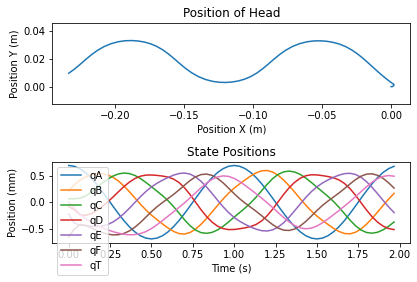

In [16]:
#Constraint Forces
if run_fit:
    states2 = run_sim(result)
    points_output = PointsOutput(points,system)
    y2 = points_output.calc(states2,t)

    fig = plt.figure()
    ax1 = plt.subplot(2,1,2)
    ax1.plot(t,states2[:,:7])
    ax1.legend(['qA','qB','qC','qD','qE','qF','qT'])
    ax1.set_title('State Positions')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Position (mm)')

    ax2 = plt.subplot(2,1,1)
    ax2.plot(y2[:,0,0],y2[:,0,1])
    ax2.axis('equal')
    ax2.set_title('Position of Head')
    ax2.set_xlabel('Position X (m)')
    ax2.set_ylabel('Position Y (m)')

    fig.tight_layout()

    print(result)
    
else:
    
    func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)
    constants = system.constant_values.copy()
    states=pynamics.integration.integrate_odeint(func1,ini,t, args=({'constants':constants},))


    points_output = PointsOutput(points,system) 
    y = points_output.calc(states,t)

    fig = plt.figure(figsize=(8, 6), dpi=80)

    ax1 = plt.subplot(2,1,1)
    ax1.plot(y[:,7,0],y[:,7,1])
    ax1.axis('equal')
    ax1.set_title('Position of Tail Tip')
    ax1.set_xlabel('Position X (m)')
    ax1.set_ylabel('Position Y (m)')

    ax2 = plt.subplot(2,1,2)
    ax2.plot(y[:,0,0],y[:,0,1])
    ax2.axis('equal')
    ax2.set_title('Position of Head')
    ax2.set_xlabel('Position X (m)')
    ax2.set_ylabel('Position Y (m)')
    
    
    fig.tight_layout()
    
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)
    
    points_output = PointsOutput(points,system)
    y = points_output.calc(states,t)
    points_output.plot_time(20)

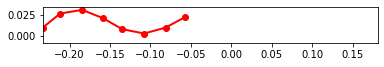

In [17]:
points_output.animate(fps = fps,movie_name = 'dynamics_free_swimming_opt_plate_area.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
    
HTML(points_output.anim.to_html5_video())

In [19]:
linear_disp = abs(states2[-1,7])/result[0]
print(linear_disp)

8.45244575462211
